This notebook assumes access to detrended, denoised signals and calculates various parameters (and uncertainties) from these signals and serves as an area for experimentation with methods for parameter estimation. The parameters estimated within this notebook are split into three different types: time-domain, frequency-domain and non-linear:

Time domain:
 - mean RR intervals
 - std RR intervals 
 - mean amplitude
 - RMSSD of differences between successive RR intervals 
 - pNN50 (%) NN50 divided by total number of RR (NN50 is the number of sucessive RR intervals that differ by more than 50ms) 
 - signal moments
 
 
Frequency Domain:
- absolute power of LF (0.04 - 0.15 Hz) band
- absolute power of HF (0.15 to 0.4Hz) band
- LF/HF ratio
- Total power (0-0.4 Hz)

Non-linear:
- Fractal dimension of dynamic attractor of signal
- std of poincare
- Shannon entropy
- recurrence rate
- detrended fluctuation analysis
- correlation dimension
- sample entropy


In [1]:
%run "Data_PreProcessing.ipynb" #allowing access to the filtered database with preprocessed signals

100%|███████████████████████████████████████████████████████████████████████████████| 229/229 [00:01<00:00, 156.85it/s]


In [2]:
from scipy.signal import find_peaks, correlate

In [3]:
test_indice = 137#set test signal to be used throughout notebook #219 is healthy
signal = denoised_signals[test_indice] 

In [4]:
def parameter_averages(parameter, health_state):
    """
    calculates healthy and unhealthy means and std of parameter for easy comparisson
    returns np.array containing: healthy mean, healthy std, unhealthy mean, unhealhty std
    """
    encoded_health_state = [True if label == 'Unhealthy' else False for label in health_state]
    
    unhealthy_param = parameter[encoded_health_state]
    healthy_param = parameter[~np.array(encoded_health_state)]
    
    unhealthy_param_av = np.mean(unhealthy_param)
    unhealthy_param_std = np.std(unhealthy_param)
    
    healthy_param_av = np.mean(healthy_param)
    healthy_param_std = np.std(healthy_param)
    
    return np.array([healthy_param_av, healthy_param_std, unhealthy_param_av, unhealthy_param_std])

def get_rri(signal):
    peaks, _ = find_peaks(signal, distance = 600)
    peak_to_peaks = peaks[1:-1]

    # calculates rr intervals
    rri = np.diff(peak_to_peaks)
    return rri
    

    

## Time Domain

### Peak to Peak times and Peak amplitude (R)

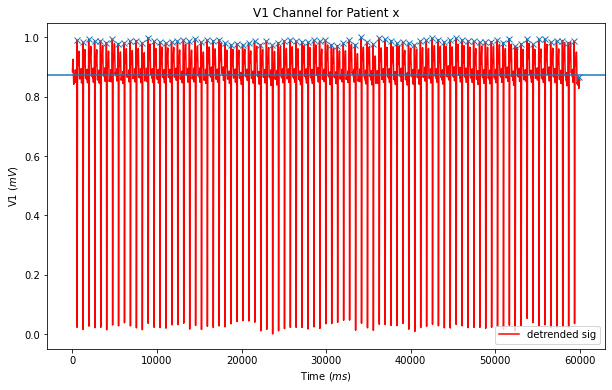

In [5]:
peaks, _ = find_peaks(signal, distance=500, height = 0.1) #can add height but still dont know how to do exactly

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(signal, color = 'red', label = 'detrended sig')
ax.plot(peaks, signal[peaks], 'x')
ax.axhline(np.median(signal))

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

identified peaks, should get rid of first and last values in it, wont hurt much even if is correct ones. I shall now implement a function to perform this for all signals in the database, may have to find a way to automatically calculate the distance between signals, find way to get rid of outliers....
- remove outliers - no because want to keep the arythmic activity!
- remove first and last values?
- dont investigate R-amplitude??

R–R intervals differing more than 20% of the mean R–R interval were removed. A linear interpolation was used in order to replace the removed beats. On the other hand, the R–R series with R–R exclusion greater than 20% were excluded from the analysis. - Spectral analysis of heart rate variability with the autoregressive method: What model order to choose?

In [6]:
#why do some signals have really large tails and some have larger peaks?

In [7]:
def RR_analysis(signal):
    peak_distances = get_rri(signal)
    
    # stastitical analysis on rr intervals
    mean_RR = np.mean(peak_distances)
    std_RR = np.std(peak_distances)
    
#     #calculating amplitude of R peak
#     peak_amp = signal[peak_to_peaks] - np.median(signal)
#     peak_amp_av = np.mean(peak_amp)
#     peak_amp_std = np.std(peak_amp)

    #RMSSD
    # computes differences between successive RR intervals for RMSSD
    diff_RR_intervals = np.diff(peak_distances)
    
    RMSSD_RR = np.sqrt(np.mean(diff_RR_intervals**2))
    
    #pNN50
    # the number of successive RR intervals that differ by more than 50 ms 
    NN50 = np.sum(np.abs(diff_RR_intervals) > 50)
    # divide by total number of RR intervals
    pNN50 = (NN50 / len(peak_distances)) * 100
    
    return mean_RR, std_RR, RMSSD_RR, pNN50


rr_means = np.zeros(shape = no_patients)
rr_stds = np.zeros(shape = no_patients)
rr_RMSSD = np.zeros(shape = no_patients)
rr_pNN50s = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    rr_mean, rr_std, rr_rmssd, rr_pNN50 = RR_analysis(signal)
    rr_means[i] = rr_mean
    rr_stds[i] = rr_std
    rr_RMSSD[i] = rr_rmssd
    rr_pNN50s[i] = rr_pNN50


In [85]:
health_state = allowed_patients.get_diagnoses()

rr_means_averages = parameter_averages(rr_means, health_state)
rr_stds_averages = parameter_averages(rr_stds, health_state)
rr_RMSSD_averages = parameter_averages(rr_RMSSD, health_state)
rr_pNN50_averages = parameter_averages(rr_pNN50s, health_state)
#amp_averages = parameter_averages(peak_amp_average, health_state)

print("Unhealthy R-R means:", rr_means_averages[2], rr_means_averages[3])
print("Healthy R-R means:", rr_means_averages[0], rr_means_averages[1])

print("Unhealthy R-R std:", rr_stds_averages[2], rr_stds_averages[3])
print("Healthy R-R std :", rr_stds_averages[0], rr_stds_averages[1])

print("Unhealthy R-R RMSSD:", rr_RMSSD_averages[2], rr_RMSSD_averages[3])
print("Healthy R-R RMSSD:", rr_RMSSD_averages[0], rr_RMSSD_averages[1])

print("Unhealthy R-R pNN50:", rr_pNN50_averages[2], rr_pNN50_averages[3])
print("Healthy R-R pNN50:", rr_pNN50_averages[0], rr_pNN50_averages[1])

# print("Unhealthy R amplitude:", amp_averages[2], amp_averages[3])
# print("Healthy R amplitude:", amp_averages[0], amp_averages[1])

Unhealthy R-R means: 825.1934758167374 116.78172084050892
Healthy R-R means: 883.6442825748669 113.85572718053493
Unhealthy R-R std: 78.94911376834462 71.95461861325572
Healthy R-R std : 62.97863721039876 60.93460628136526
Unhealthy R-R RMSSD: 100.92264809375122 99.59979913049436
Healthy R-R RMSSD: 65.13632492102461 75.89440032851806
Unhealthy R-R pNN50: 27.11601784650672 29.891544217421007
Healthy R-R pNN50: 18.204555717330734 21.730444055490388


The above suggest that in the case of the R-R time the means are different however the standard deviations are similar, however the opposite is the case for the amplitudes.

In [81]:
from scipy.stats import skew, kurtosis

def get_moments(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skew_ecg = skew(signal)
    kurtosis_ecg = kurtosis(signal)
    return mean, std, skew_ecg, kurtosis_ecg

means = np.zeros(shape = no_patients)
stds = np.zeros(shape = no_patients)
skews = np.zeros(shape = no_patients)
kurtosiss = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    mean, std, ecg_skew, ecg_kurtosis = get_moments(signal)
    means[i] = mean
    stds[i] = std
    skews[i] = ecg_skew
    kurtosiss[i] = ecg_kurtosis
    
    

In [84]:
means_averages = parameter_averages(means, health_state)
stds_averages = parameter_averages(stds, health_state)
skews_averages = parameter_averages(skews, health_state)
kurtosis_averages = parameter_averages(kurtosiss, health_state)
#amp_averages = parameter_averages(peak_amp_average, health_state)

print("Unhealthy means:", means_averages[2], means_averages[3])
print("Healthy means:", means_averages[0], means_averages[1])

print("Unhealthy std:", stds_averages[2], stds_averages[3])
print("Healthy std :", stds_averages[0], stds_averages[1])

print("Unhealthy skews:", skews_averages[2], skews_averages[3])
print("Healthy skews:", skews_averages[0], skews_averages[1])

print("Unhealthy kurtosis:", kurtosis_averages[2], kurtosis_averages[3])
print("Healthy kurtosis:", kurtosis_averages[0], kurtosis_averages[1])

Unhealthy means: 0.7015159295794294 0.1651770576330125
Healthy means: 0.7444328822393981 0.08450232245938545
Unhealthy std: 0.12828689308721844 0.029006883482026184
Healthy std : 0.1146917239140083 0.020223981769336274
Unhealthy skews: -2.646753414673815 2.0407259769220216
Healthy skews: -3.716154120700621 0.8585484240202387
Unhealthy kurtosis: 13.812740358781623 6.887681360996892
Healthy kurtosis: 18.74178303888289 5.851447527123128


## Frequency Domain

### Power Bands

In [10]:
from scipy.signal import welch
from scipy.interpolate import interp1d

fs = 1000 #Hz
fs_interpolate = 3 #Hz

peaks, _ = find_peaks(signal, distance=600)
rr_intervals = np.diff(peaks)/fs # RR intervals in seconds, fs is the sampling frequency of the original signal
    
# Time points of the RR intervals
rr_times = np.cumsum(rr_intervals)
rr_times = np.insert(rr_times, 0, 0)  # Add time zero at the beginning

# Interpolation
interpolated_time = np.arange(0, rr_times[-2], 1/fs_interpolate)  # Interpolated time vector

interpolated_rr = interp1d(rr_times[:-1], rr_intervals, kind='cubic')(interpolated_time)

f, psd = welch(interpolated_rr, fs=fs_interpolate, nperseg=128)

print(f)
print(psd)

# Define frequency bands
lf_band = (0.04, 0.15)
hf_band = (0.15, 0.40)

# Integrate the power spectral density over the frequency bands
lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])

[0.        0.0234375 0.046875  0.0703125 0.09375   0.1171875 0.140625
 0.1640625 0.1875    0.2109375 0.234375  0.2578125 0.28125   0.3046875
 0.328125  0.3515625 0.375     0.3984375 0.421875  0.4453125 0.46875
 0.4921875 0.515625  0.5390625 0.5625    0.5859375 0.609375  0.6328125
 0.65625   0.6796875 0.703125  0.7265625 0.75      0.7734375 0.796875
 0.8203125 0.84375   0.8671875 0.890625  0.9140625 0.9375    0.9609375
 0.984375  1.0078125 1.03125   1.0546875 1.078125  1.1015625 1.125
 1.1484375 1.171875  1.1953125 1.21875   1.2421875 1.265625  1.2890625
 1.3125    1.3359375 1.359375  1.3828125 1.40625   1.4296875 1.453125
 1.4765625 1.5      ]
[4.06391358e-04 5.22628824e-04 2.08244906e-05 3.78779425e-04
 6.46083097e-05 4.50115336e-04 7.03800382e-04 4.15333260e-04
 3.87503273e-04 5.15400652e-04 8.96278647e-04 8.62273529e-04
 9.17428444e-04 4.35164974e-04 4.78520541e-04 5.68455965e-04
 5.68567983e-04 4.90730066e-04 2.55645241e-04 1.48544821e-04
 1.71460781e-04 2.30322530e-04 1.23437404e-

In [11]:
print(lf_power, hf_power)
print(lf_power/hf_power) #should be about 2 if healthy

2.9433175955795928e-05 0.00014256153916212345
0.20645944290994228


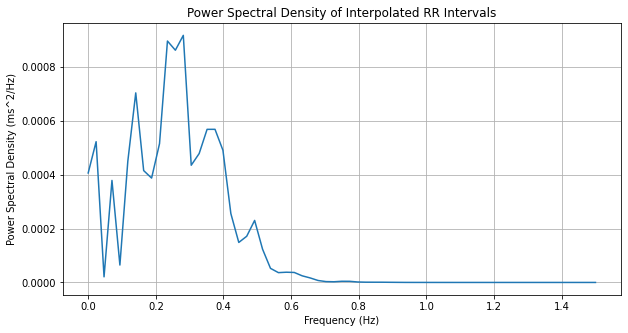

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(f, psd)
plt.title('Power Spectral Density of Interpolated RR Intervals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (ms^2/Hz)')
plt.grid()
plt.show()

In [13]:
import biosppy

f, psd = biosppy.signals.tools.welch_spectrum(signal) #size = len(signal))
print(f)
print(psd)

# Integrate the power spectral density over the frequency bands
lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [14]:
print(lf_power, hf_power)

0.0 0.0


- could make signal longer?? think is working through own method tho, why not using the built in package??

## Using hrv-analysis, biosppy pyhrv python package
Here I shall attempt to install and use this package, I shall compare the results for the above measures before confirming its accuracy to use to calculate other features.
- both need pip installation

In [15]:
#i shall first compare the rr-intervals I have calculated with those calculated by biosppy
import biosppy

rpeaks = biosppy.signals.ecg.christov_segmenter(signal)['rpeaks']


In [16]:
peaks, _ = find_peaks(signal, distance = 600)

In [17]:
print(rpeaks)
print(peaks)

[  295  1100  1901  2705  3513  4324  5136  5949  6758  7566  8374  9180
  9982 10782 11583 12386 13184 13978 14772 15567 16361 17153 17947 18745
 19542 20343 21143 21943 22744 23539 24334 25128 25924 26719 27518 28316
 29120 29927 30738 31191 32193 33032 33852 34655 35457 36264 37083 37902
 38722 39185 40200 41065 41898 42717 43531 44355 45180 46008 46828 47651
 48479 49304 50124 50943 51761 52584 53408 54230 55047 55863 56683 57493
 58300 59101 59898]
[  295  1100  1901  2705  3513  4324  5136  5949  6758  7566  8374  9180
  9982 10782 11583 12386 13184 13978 14772 15567 16361 17153 17947 18745
 19542 20343 21143 21943 22744 23539 24334 25128 25924 26719 27518 28316
 29120 29927 30738 31441 32193 33032 33852 34655 35457 36264 37083 37902
 38722 39445 40200 41065 41898 42717 43531 44355 45180 46008 46828 47651
 48479 49304 50124 50943 51761 52584 53408 54230 55047 55863 56683 57493
 58300 59101 59898]


the above are the same which is good, should still investiagte removal of outliers/ectopic beats etc

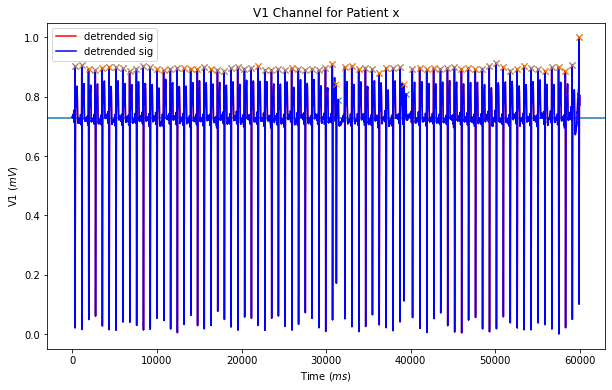

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(signal, color = 'red', label = 'detrended sig')
ax.plot(peaks, signal[peaks], 'x')
ax.axhline(np.median(signal))

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.plot(signal, color = 'blue', label = 'detrended sig')
ax.plot(rpeaks, signal[rpeaks], 'x')



ax.legend()
plt.show()

In [19]:
#cannot get any of the packages to work :((

In [20]:
import pyhrv.tools as tools

#compute NNI
nni = tools.nn_intervals(rpeaks)

In [21]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values

# rr_intervals_list contains integer values of RR-interval
rr_intervals_list = rpeaks

# This remove outliers from signal
rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list,  
                                                low_rri=300, high_rri=2000)
# This replace outliers nan values with linear interpolation
interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,
                                                   interpolation_method="linear")

# This remove ectopic beats from signal
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
# This replace ectopic beats nan values with linear interpolation
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

AttributeError: module 'numpy' has no attribute 'asscalar'

In [ ]:
from hrvanalysis import get_time_domain_features

time_domain_features = get_time_domain_features(rpeaks)

## Non-Linear Domain

### Standard deviation of Poincare Plot
plot of each rr interval against the next, essentially a phase plot

In [22]:
def plot_poincare(rr_intervals):
    x = rr_intervals[:-1]
    y = rr_intervals[1:]
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=10, alpha=0.5)
    plt.plot(x, x, color='red', linestyle='--')  # Line of identity (y = x)
    plt.title('Poincaré Plot')
    plt.xlabel('RR_n (ms)')
    plt.ylabel('RR_{n+1} (ms)')
    plt.grid(True)
    plt.axis('equal')  # Ensure aspect ratio is equal
    plt.show()
    
def calculate_poincare_sd(signal):
    #get rr intervals
    rr_intervals = get_rri(signal)
    
    #separating into subsequent coordinates for Poincaré plot
    rr_n = rr_intervals[:-1]
    rr_n1 = rr_intervals[1:]
    
    #calculating SD1, perpendicular to y=x
    diff_rr = rr_n - rr_n1
    sd1 = np.sqrt(np.var(diff_rr/np.sqrt(2)))
    
    # calculating SD2, along y=x
    sum_rr = rr_n + rr_n1
    sd2 = np.sqrt(np.var(sum_rr/np.sqrt(2)))
   
    return sd1, sd2

In [23]:
rr_intervals = get_rri(signal)

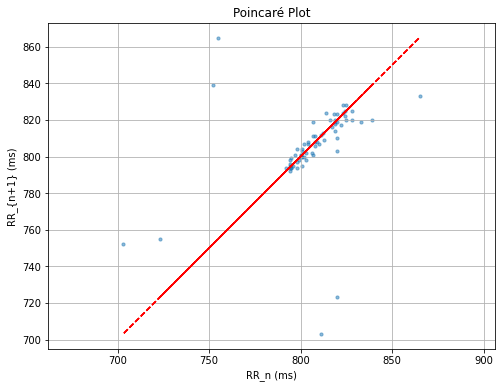

In [24]:
plot_poincare(rr_intervals)

In [25]:
#remove outliers or leave in because might portray arrythmias?

In [26]:
sd1, sd2 = calculate_poincare_sd(signal)
print(sd1, sd2)

18.189534214200688 26.04383026785478


### Sample Entropy
quantifies the unpredictability of fluctuations in the data set

In [27]:
def calculate_sample_entropy(signal, m=2, r=0.2):
    rr_intervals = get_rri(signal)
    N = len(rr_intervals)
    r *= np.std(rr_intervals)  # tolerance r is usually set as a fraction of the standard deviation
    
    def _phi(m):
        X = np.array([rr_intervals[i:i + m] for i in range(N - m + 1)])
        C = np.sum(np.max(np.abs(X[:, None] - X[None, :]), axis=2) <= r, axis=0) - 1
        return np.sum(C) / (N - m + 1)
    return -np.log(_phi(m + 1) / _phi(m))

In [28]:
samp_en = calculate_sample_entropy(signal)
print("Sample Entropy:", samp_en)

Sample Entropy: 0.6350433116331533


### Shannon Entropy 
also known as information entropy, is a measure of the uncertainty or randomness in a set of values

In [29]:
def calculate_shannon_entropy(rr_intervals, num_bins=10):
    # discretize RR intervals into bins and calculate probabilities
    hist, bin_edges = np.histogram(rr_intervals, bins=num_bins, density=True)
    
    probabilities = hist / np.sum(hist)
    
    # Calculate Shannon Entropy using equation
    shannon_entropy = -np.sum(probabilities * np.log2(probabilities + 1e-12))  # adding a small value to avoid log(0)
    
    return shannon_entropy

In [30]:
shannon_en = calculate_shannon_entropy(rr_intervals)
print('Shannon Entropy:', shannon_en)

Shannon Entropy: 2.095471983030163


### Comparisson of Healthy and Unhealthy for non-linear domain HRV features

In [31]:
SD1s = np.zeros(shape = no_patients)
SD2s = np.zeros(shape = no_patients)
sample_ens = np.zeros(shape = no_patients)
shannon_ens = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    SD1, SD2 = calculate_poincare_sd(signal)
    SD1s[i] = SD1
    SD2s[i] = SD2
    sample_ens[i] = calculate_sample_entropy(signal)
    shannon_ens[i] = calculate_shannon_entropy(signal)

In [32]:
SD1_averages = parameter_averages(SD1s, health_state)
SD2_averages = parameter_averages(SD2s, health_state)
sample_entropy_averages = parameter_averages(sample_ens, health_state)
shannon_entropy_averages = parameter_averages(shannon_ens, health_state)

print("Unhealthy SD1s:", SD1_averages[2], SD1_averages[3])
print("Healthy SD1s:", SD1_averages[0], SD1_averages[1])

print("Unhealthy SD2s:", SD2_averages[2], SD2_averages[3])
print("Healthy SD2s:", SD2_averages[0], SD2_averages[1])

print("Unhealthy SampleEn:", sample_entropy_averages[2], sample_entropy_averages[3])
print("Healthy SampleEn:", sample_entropy_averages[0], sample_entropy_averages[1])

print("Unhealthy ShannonEn:", shannon_entropy_averages[2], shannon_entropy_averages[3])
print("Healthy ShannonEn:", shannon_entropy_averages[0], shannon_entropy_averages[1])


Unhealthy SD1s: 71.34834470170475 70.4233572931025
Healthy SD1s: 46.03830079280871 53.657838703522025
Unhealthy SD2s: 83.47975729691551 76.19869231360367
Healthy SD2s: 74.14020658158967 69.12466494546108
Unhealthy SampleEn: inf nan
Healthy SampleEn: 1.4285068922591924 0.5728840755268262
Unhealthy ShannonEn: 1.533715842382233 0.3653034181067842
Healthy ShannonEn: 1.3297251147464324 0.3306809045323388


### Correlation Dimension

experimented with a couple of methods but all lead to memory issues.

In [40]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alottttt faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau


In [68]:
#this takes foreverrrrrr - fixed using scipy.correlate
tau = np.zeros(shape = no_patients, dtype=int)
for i in tqdm(range(0, no_patients)):
    tau[i] = find_time_delay(denoised_signals[i])

100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:07<00:00, 29.70it/s]


In [54]:
#original embedding of time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

#     N = len(signal)
#     M = N - (m - 1) * tau
#     if M <= 0:
#         raise ValueError("Time series too short for given m and tau")
#     phase_space = np.zeros((M, m))
#     for i in range(m):
#         phase_space[:, i] = signal[i * tau : i * tau + M]
#     return phase_space

# embedding dimension M
M = 3

#creates list of embedded arrays i.e. no_patients * len(embedded) * M
embedded_signals = []
for i in tqdm(range(0, no_patients)):
    embedded_signals.append(embed_time_series(denoised_signals[i], tau[i], M))

100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.40it/s]


In [55]:
#calculates the pairwise euclidean distances for each reconstructed vector X(i), X(j)

from scipy.spatial.distance import pdist, squareform

print(embedded_signals[2].shape[0])

59880


In [56]:
from scipy.spatial.distance import pdist, squareform

def count_pairs_within_radius(distance_matrix, r):
    N = distance_matrix.shape[0]
    count = np.sum((distance_matrix < r) & (distance_matrix > 0))  # Exclude self-pairs
    return count


r = 0.5 #setting radius with which to check that distances are within
pair_count = np.zeros(shape = no_patients)
for phase_space in embedded_signals:
    #calculates the pairwise euclidean distances for each reconstructed vector X(i), X(j)
    distances = pdist(phase_space, 'euclidean')

    # Convert distances to a square form
    distance_matrix = squareform(distances)
    
    pair_count = count_pairs_within_radius(distance_matrix, r)
    
    

MemoryError: Unable to allocate 13.4 GiB for an array with shape (1795293081,) and data type float64

In [53]:
from scipy.spatial.distance import euclidean


# using incremental pairwise distance calculation due to memory allocation issues
def count_pairs_within_radius(phase_space, r):
    M = phase_space.shape[0]
    count = 0
    for i in range(M):
        for j in range(i + 1, M):
            if euclidean(phase_space[i], phase_space[j]) < r:
                count += 1
    return count

r = 0.5 #setting radius with which to check that distances are within
pair_count = np.zeros(shape = no_patients)
for i, phase_space in tqdm(enumerate(embedded_signals)):
    pair_count = count_pairs_within_radius(phase_space, r)
    

0it [00:18, ?it/s]


KeyboardInterrupt: 

In [70]:
import nolds

corr_dimen = nolds.corr_dim(denoised_signals[0], emb_dim=2)

KeyboardInterrupt: 

### Detrended Fluctuation Analysis

In [62]:
import nolds

dfa = nolds.dfa(denoised_signals[0])

In [63]:
print(dfa)

1.1215825283049579


### Mulit - Fractal Analysis

- use signals to reconstruct dynamical attractors, used to quantify differences in signals
- calculate time delay, point where autocorrelation drops to 1/e
- each time series is then embedded into M dimension
    - M decided at point at which any fractal measure saturates, e.g $D_2$, correlation dimension.
- perform SVD on embedded signal to get embedded attractor
- perform fractal analysis on embedded attractor

In [34]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alottttt faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau



In [35]:
#this takes foreverrrrrr - fixed using scipy.correlate
tau = np.zeros(shape = no_patients, dtype=int)
for i in tqdm(range(0, no_patients)):
    tau[i] = find_time_delay(denoised_signals[i])

100%|███████████████████████████████████████████████████████████████████████████████| 229/229 [00:01<00:00, 155.75it/s]


In [36]:
#print(tau)

In [38]:
#embedding time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

# embedding dimension M
M = 5 

#creates list of embedded arrays i.e. no_patients * len(embedded) * M
embedded_signals = []
for i in tqdm(range(0, no_patients)):
    embedded_signals.append(embed_time_series(denoised_signals[i], tau[i], M))

100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:12<00:00, 17.69it/s]


(59856, 5)


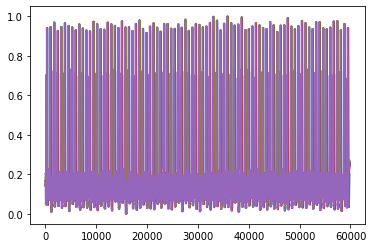

In [39]:
fig, axes = plt.subplots()

print(embedded_signals[3].shape)
axes.plot(embedded_signals[0])
plt.show()

In [71]:
# performing SVD

from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd

# Standardize the embedded signal
scaler = StandardScaler()
embedded_signal_std = scaler.fit_transform(embedded_signals[0])

# Perform SVD
U, S, VT = svd(embedded_signal_std, full_matrices=False)

# Get the principal components
PCs = U @ np.diag(S)

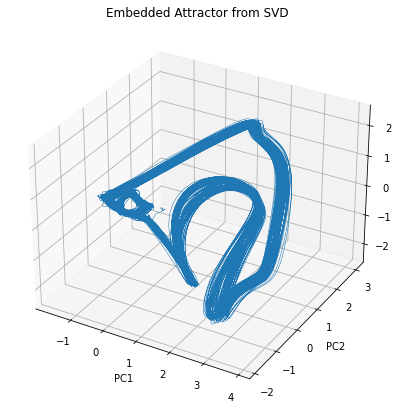

In [72]:
#visualising attractors in 3D
 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot the first three principal components
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(PCs[:, 0], PCs[:, 1], PCs[:, 2], lw=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Embedded Attractor from SVD')

plt.show()

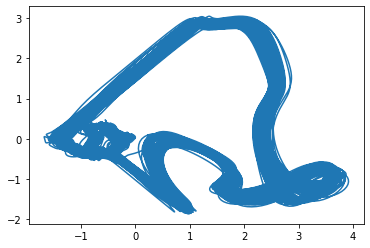

In [73]:
#in 2D

fig, axes = plt.subplots()

axes.plot(PCs[:, 0], PCs[:, 1])

In [74]:
#calculating fractal dimension through box counting
def box_counting(data, box_sizes):
    counts = []
    for size in box_sizes:
        count = 0
        # creates grid
        grid = np.ceil(data / size).astype(int)
        #counts unique boxes
        unique_boxes = np.unique(grid, axis=0)
        count = len(unique_boxes)
        counts.append(count)
    return counts

def fractal_dimension(data, box_sizes):
    counts = box_counting(data, box_sizes)
    log_box_sizes = np.log(box_sizes)
    log_counts = np.log(counts)
    
    # Perform linear regression to find the slope of the log-log plot
    coeffs = np.polyfit(log_box_sizes, log_counts, 1)
    return -coeffs[0]  # The fractal dimension is the negative slope

# Define box sizes
box_sizes = np.logspace(-1, 1, num=10)  # Adjust as needed

# Calculate the fractal dimension
fd = fractal_dimension(PCs[:, :3], box_sizes)  # Using the first three principal components

In [75]:
print(f"Fractal Dimension: {fd}")

Fractal Dimension: 1.4205726548026438


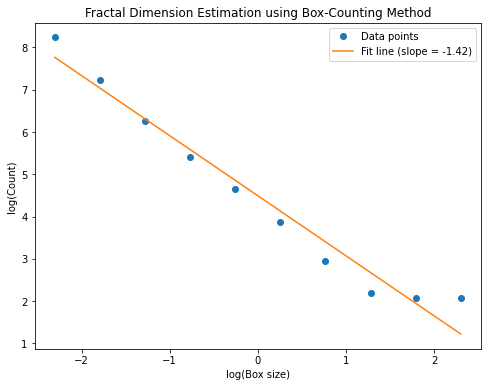

In [76]:
# plotting the log-log plot for the box-counting method
import matplotlib.pyplot as plt

log_box_sizes = np.log(box_sizes)
log_counts = np.log(box_counting(PCs[:, :3], box_sizes))

plt.figure(figsize=(8, 6))
plt.plot(log_box_sizes, log_counts, 'o', label='Data points')
plt.plot(log_box_sizes, np.polyval(np.polyfit(log_box_sizes, log_counts, 1), log_box_sizes),
         label=f'Fit line (slope = {-fd:.2f})')
plt.xlabel('log(Box size)')
plt.ylabel('log(Count)')
plt.legend()
plt.title('Fractal Dimension Estimation using Box-Counting Method')
plt.show()

Code to calculate fractal dimension only for each patient:

In [77]:
#research this properly before doing this final implementation but this allows calculation of just fractal dimension from all signals
def calc_fractal_dim(signal):
    
    scaler = StandardScaler()
    embedded_signal_std = scaler.fit_transform(signal)

    # performs SVD and obtains principal components
    U, S, VT = svd(embedded_signal_std, full_matrices=False)
    PCs = U @ np.diag(S)
    
    # define box sizes
    box_sizes = np.logspace(-1, 1, num=10)  # research/try this out
    
    # calculate the fractal dimension
    fd = fractal_dimension(PCs[:, :3], box_sizes)  # uses the first three principal components
    return fd

fd = np.zeros(shape = no_patients)

for i in tqdm(range(0, no_patients)):
    fd[i] = calc_fractal_dim(embedded_signals[i])
    


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [01:56<00:00,  1.97it/s]


In [78]:
fd_averages = parameter_averages(fd, health_state)
print(fd_averages)

[1.40718718 0.06499179 1.4376354  0.11698063]
